In [38]:
import pandas as pd
import numpy as np
import json
path = './dataset/FOOTBALL/football_10.json'

In [39]:
import fasttext
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [40]:
with open(path) as f:
    data_json = json.load(f)

In [41]:
len(data_json)

257759

In [42]:
j = 0
for i in data_json.keys():
    if j>5:
        break
    j+=1
    print(data_json[i])
    

{'label': {'player': 'george blanda', 'position': 'QB', 'race': 'white', 'reference': 'george blanda', 'teams': ['houston_oilers', 'dallas_texans'], 'year': '1962'}, 'mention': ['grissom', 'is', 'teeing', 'up', 'the', 'ball', 'as', 'the', 'honorary', 'referee', 'shaky', '<player>', 'lander', 'will', 'kick', 'off', 'for', 'houston', 'these']}
{'label': {'player': 'dave grayson', 'position': 'DB', 'race': 'nonwhite', 'reference': 'grayson', 'teams': ['houston_oilers', 'dallas_texans'], 'year': '1962'}, 'mention': ['houston', 'beating', 'dallas', 'in', 'dallas', 'when', 'who', 'the', 'football', 'hey', 'and', 'james', 'is', '28', '<player>', 'is', '45', 'hitting', 'a']}
{'label': {'player': 'dave grayson', 'position': 'DB', 'race': 'nonwhite', 'reference': 'grayson', 'teams': ['houston_oilers', 'dallas_texans'], 'year': '1962'}, 'mention': ['when', 'who', 'the', 'football', 'hey', '<player>', 'and', 'james', 'is', '28', 'is', '45', 'hitting', 'a', 'sideline', 'clara', 'were', 'waiting', '

In [43]:
df_lists = []
for i in data_json.keys():
    temp = []
    label = data_json[i]['label']
    temp.append(label['player'])
    temp.append(label['position'])
    temp.append(label['race'])
    temp.append(label['reference'])
    temp.append(label['teams'][0])
    temp.append(label['teams'][1])
    temp.append(label['year'])
    temp.append(data_json[i]['mention'])
    temp.append(' '.join(data_json[i]['mention']))
    df_lists.append(temp)

data_df = pd.DataFrame(df_lists, columns= ['Name', 'Position', 'Race', 'Reference', 'Team1', 
                                           'Team2', 'Year', 'Mention_tokens', 'Mention_text' ])

In [44]:
data_df.head()

,Name,Position,Race,Reference,Team1,Team2,Year,Mention_tokens,Mention_text
0,george blanda,QB,white,george blanda,houston_oilers,dallas_texans,1962,"[grissom, is, teeing, up, the, ball, as, the, ...",grissom is teeing up the ball as the honorary ...
1,dave grayson,DB,nonwhite,grayson,houston_oilers,dallas_texans,1962,"[houston, beating, dallas, in, dallas, when, w...",houston beating dallas in dallas when who the ...
2,dave grayson,DB,nonwhite,grayson,houston_oilers,dallas_texans,1962,"[when, who, the, football, hey, <player>, and,...",when who the football hey <player> and james i...
3,len dawson,QB,white,dawson,houston_oilers,dallas_texans,1962,"[their, 28th, they, backfield, now, for, dalla...",their 28th they backfield now for dallas will ...
4,abner haynes,RB,nonwhite,abner haynes,houston_oilers,dallas_texans,1962,"[backfield, now, for, dallas, will, be, when, ...",backfield now for dallas will be when <player>...


In [45]:
len(data_df)

257759

#### Check for missing Race information on players

In [46]:
data_df.Race.isnull().values.any()

False

In [47]:
data_df.Race.isnull().sum()

0

No missing data

#### Wordclouds

In [48]:
import matplotlib.pyplot as plt

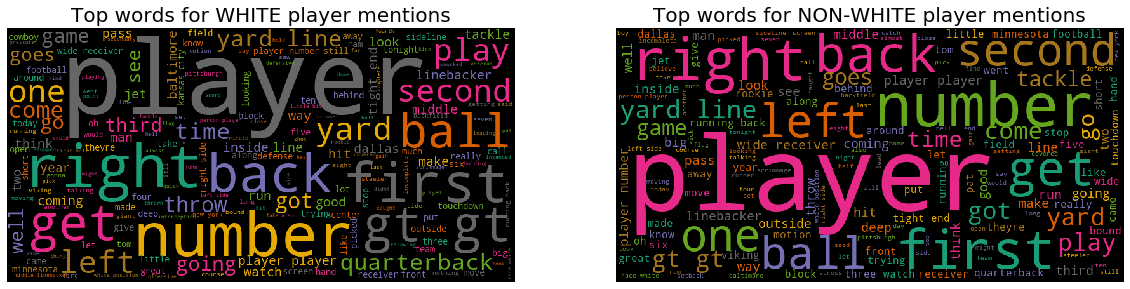

In [49]:
n_posts = 10000
whites = ' '.join(data_df[data_df['Race'] == 'white']['Mention_text'].str.lower().values[:n_posts])
nonwhites = ' '.join(data_df[data_df['Race'] == 'nonwhite']['Mention_text'].str.lower().values[:n_posts])

wordcloud_W = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(whites)
wordcloud_NW = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(nonwhites)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_W)
ax[0].set_title('Top words for WHITE player mentions',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_NW)
ax[1].set_title('Top words for NON-WHITE player mentions',fontsize = 20)
ax[1].axis("off")

plt.show()

Wordclouds seem very similar - not much can be said visually

### Building a basic Naive Bayes model

In [50]:
data_df['label'] = data_df.Race.map({'white': 0, 'nonwhite': 1})

# preprocessing 

# lower casing all letters 
data_df['Mention_text'] = data_df.Mention_text.map(lambda x: x.lower())

# removing punctuation
data_df['Mention_text'] = data_df.Mention_text.str.replace('[^\w\s]', '')

In [51]:
# first without stemming
# from nltk.stem import PorterStemmer

# stemmer = PorterStemmer()

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
counts = count_vect.fit_transform(data_df['Mention_text'])

In [52]:
# TFIDF
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts_tfidf = transformer.transform(counts)

In [53]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts_tfidf, data_df['label'], test_size=0.2, random_state=42)

In [54]:
# training the Naive Bayes
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

In [55]:
import numpy as np

predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.6688974239602731


In [56]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predicted))

[[  782 16607]
 [  462 33701]]


In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1_score(y_test, predicted, average='macro')

0.4409338757992359

In [58]:
f1_score(y_test, predicted, average='weighted')

0.557093557346465

In [59]:
recall_score(y_test, predicted)

0.9864765974885109

In [60]:
precision_score(y_test, predicted)

0.6698934563091358